In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pandas as pd 
import numpy as np
import random
result = pd.read_csv('../data/2_before2016.csv').dropna()
table = result.loc[:,'actq':'actual']
N = table.shape[0]
train_N = int(0.9*N)
valid_N = N - train_N

result1 = pd.read_csv('../data/2_after2016.csv').dropna()
table1 = result1.loc[:, 'actq':'actual']
N_test = table1.shape[0]

y = table['actual']
x = table.drop('meanest', axis = 1).drop('actual', axis = 1)
mean = np.mean(x, axis=0)
std = np.std(x, axis=0)
x = (x - mean)/std

y1 = table1['actual']
x1 = table1.drop('meanest', axis = 1).drop('actual', axis = 1)
#k = x.drop('lastactual', axis = 1)
#x.loc[:,'actq':'lastfincfy'] = (k - np.mean(k, axis=0))/np.std(k, axis=0)
x1 = (x1 - mean)/std

target = torch.tensor(y.values.astype(np.float32))
train = torch.tensor(x.values.astype(np.float32))

target1 = torch.tensor(y1.values.astype(np.float32))
train1 = torch.tensor(x1.values.astype(np.float32))

batch_size_train = 64 # We use a small batch size here for training
batch_size_test = 50000

train_tensor = torch.utils.data.TensorDataset(train, target) 

test_dataset = torch.utils.data.TensorDataset(train1, target1)

train_dataset, valid_dataset = torch.utils.data.random_split(train_tensor, [train_N, valid_N])

train_loader = torch.utils.data.DataLoader(train_dataset,
                                           batch_size=batch_size_train, 
                                           shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_dataset,
                                           batch_size=batch_size_test, 
                                           shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset,
                                          batch_size=batch_size_test, 
                                          shuffle=True)

In [3]:
## Now we can start to build our nn model
## We first import the pytorch nn module and optimizer

## Then define the model class
class NN5(nn.Module):
    def __init__(self):
        super(NN5, self).__init__()
        #fully connected layer
        self.fc1 = nn.Linear(11, 32)
        self.fc2 = nn.Linear(32, 16)
        self.fc3 = nn.Linear(16, 8)
        self.fc4 = nn.Linear(8, 1)
    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        x = F.relu(x)
        x = self.fc4(x)
        return x


device = "cpu"
model = NN5().to(device) #using cpu here

In [4]:
def withinten(y_true, y_pred):
    sum1 = 0
    for i in range(len(y_pred)):
        if(y_pred[i] < 1.1*y_true[i] and y_pred[i] > 0.9*y_true[i]):
            sum1+=1
    return sum1/len(y_pred)

In [5]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
##define train function
loss_fn = nn.MSELoss(reduction='mean')
trainloss = []
validloss = []
def train(model, device, train_loader, optimizer, epoch, log_interval=100):
    model.train()
    loss1 = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = loss_fn(output.squeeze(), target)
        loss.backward()
        optimizer.step()
        loss1 += loss.item() * len(output)
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
    trainloss.append(loss1/train_N)

def validation(model, device, valid_loader):
    model.eval()
    with torch.no_grad():
        loss = 0
        for data, target in valid_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss += loss_fn(output.squeeze(), target).item() * len(output)
    validloss.append(loss/valid_N)
    print('Valid Loss: {:.3f}\n'.format(loss/valid_N))

##define test function
def test(model, device, test_loader):
    model.eval()
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = loss_fn(output.squeeze(), target).item()
            r2_nn0 = r2_score(target, output.squeeze())
            within10 = withinten(target, output.squeeze())
    return loss, r2_nn0, within10


In [6]:
learning_rate = 1e-2
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

In [11]:
num_epoch = 100
for epoch in range(1, num_epoch + 1):
    train(model, device, train_loader, optimizer, epoch)
    validation(model, device, valid_loader)

Train Epoch: 1 [0/19422 (0%)]	Loss: 0.120318
Train Epoch: 1 [6400/19422 (33%)]	Loss: 0.064707
Train Epoch: 1 [12800/19422 (66%)]	Loss: 0.083768
Train Epoch: 1 [19200/19422 (99%)]	Loss: 0.078050
Valid Loss: 0.120

Train Epoch: 2 [0/19422 (0%)]	Loss: 0.126454
Train Epoch: 2 [6400/19422 (33%)]	Loss: 0.338786
Train Epoch: 2 [12800/19422 (66%)]	Loss: 0.058326
Train Epoch: 2 [19200/19422 (99%)]	Loss: 0.055527
Valid Loss: 0.112

Train Epoch: 3 [0/19422 (0%)]	Loss: 0.066261
Train Epoch: 3 [6400/19422 (33%)]	Loss: 0.055737
Train Epoch: 3 [12800/19422 (66%)]	Loss: 0.085373
Train Epoch: 3 [19200/19422 (99%)]	Loss: 0.062459
Valid Loss: 0.099

Train Epoch: 4 [0/19422 (0%)]	Loss: 0.022560
Train Epoch: 4 [6400/19422 (33%)]	Loss: 0.051397
Train Epoch: 4 [12800/19422 (66%)]	Loss: 0.082582
Train Epoch: 4 [19200/19422 (99%)]	Loss: 0.285077
Valid Loss: 0.102

Train Epoch: 5 [0/19422 (0%)]	Loss: 0.047842
Train Epoch: 5 [6400/19422 (33%)]	Loss: 0.124108
Train Epoch: 5 [12800/19422 (66%)]	Loss: 0.212691
Trai

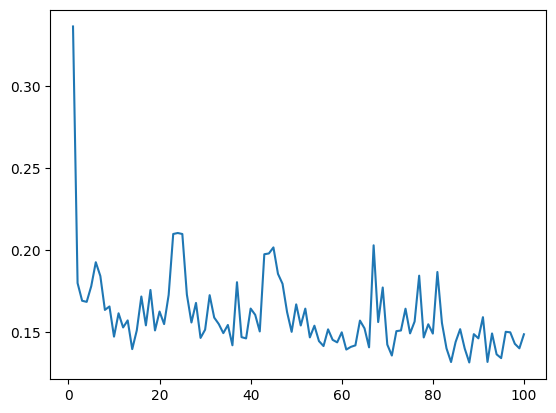

In [8]:
from matplotlib import pyplot as plt
plt.plot(range(1, num_epoch+1), trainloss)
#plt.savefig('nn5_train.png')

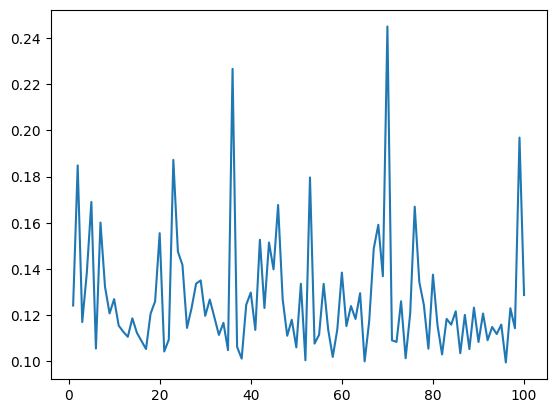

In [9]:
plt.plot(range(1, num_epoch+1), validloss)
#plt.savefig('nn5_valid.png')

In [12]:
loss, r2, within10 = [], [], []
for i in range(100):
    lossi, r2i, within10i = test(model, device, test_loader)
    loss.append(lossi)
    r2.append(r2i)
    within10.append(within10i)

print('Test Loss: {:.3f}'.format(np.mean(loss)))
print('R2: {:.3f}'.format(np.mean(r2)))
print('Within10%: {:.3f}'.format(np.mean(within10)))

Test Loss: 1.082
R2: 0.637
Within10%: 0.283
